In [1]:
!pip install gym >/dev/null

In [2]:
!pip install JSAnimation >/dev/null

In [3]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

## Step 2: Playing Pong

In [4]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=5e454aa529fe5d43a10f2686c7c445f6262824f0476a883049a805fc99a2fa23
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [5]:
import gym
env = gym.make('Pong-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v4`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.


In [6]:
env.action_space

Discrete(6)

In [7]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [8]:
# Run a demo of the environment
observation = env.reset()
cumulated_reward = 0

frames = []
for t in range(1000):
#     print(observation)
    frames.append(env.render(mode = 'rgb_array'))
    # very stupid agent, just makes a random action within the allowd action space
    action = env.action_space.sample()
#     print("Action: {}".format(t+1))    
    observation, reward, done, info = env.step(action)
#     print(reward)
    cumulated_reward += reward
    if done:
        print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
        break
print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))

env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:298: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  "No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps."
/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which r

Episode finished without success, accumulated reward = -18.0


In [9]:
def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

## Step 3: Policy Gradient from Scratch

In [10]:
import numpy as np

# model initialization
H = 800 # number of hidden layer neurons
D = 80 * 80 # input dimensionality: 80x80 grid
model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
model['W2'] = np.random.randn(H) / np.sqrt(H)

# import pickle
# model = pickle.load(open('model.pkl', 'rb'))

In [11]:
# hyperparameters
batch_size = 10 # every how many episodes to do a param update?
# learning_rate = 1e-4
learning_rate = 1e-4
 
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r, dtype=np.float32)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_backward(epx, eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

def train_model(env, model, total_episodes = 100):
  hist = []
  observation = env.reset()

  prev_x = None # used in computing the difference frame
  xs,hs,dlogps,drs = [],[],[],[]
  running_reward = None
  reward_sum = 0
  episode_number = 0

  while True:
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

    # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
      episode_number += 1

      # stack together all inputs, hidden states, action gradients, and rewards for this episode
      epx = np.vstack(xs)
      eph = np.vstack(hs)
      epdlogp = np.vstack(dlogps)
      epr = np.vstack(drs)
      xs,hs,dlogps,drs = [],[],[],[] # reset array memory

      # compute the discounted reward backwards through time
      discounted_epr = discount_rewards(epr)
      # standardize the rewards to be unit normal (helps control the gradient estimator variance)
      discounted_epr -= np.mean(discounted_epr)
      discounted_epr /= np.std(discounted_epr)

      epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
      grad = policy_backward(epx, eph, epdlogp)
      for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

      # perform rmsprop parameter update every batch_size episodes
      if episode_number % batch_size == 0:
        for k,v in model.items():
          g = grad_buffer[k] # gradient
          rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
          model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
          grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

      # boring book-keeping
      running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
      hist.append((episode_number, reward_sum, running_reward))
      print ('resetting env. episode %f, reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))
      reward_sum = 0
      observation = env.reset() # reset env
      prev_x = None
      if episode_number == total_episodes: return hist

      if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))

In [12]:
%time hist1 = train_model(env, model, total_episodes=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


resetting env. episode 1.000000, reward total was -21.000000. running mean: -21.000000
resetting env. episode 2.000000, reward total was -21.000000. running mean: -21.000000
resetting env. episode 3.000000, reward total was -21.000000. running mean: -21.000000
resetting env. episode 4.000000, reward total was -20.000000. running mean: -20.990000
resetting env. episode 5.000000, reward total was -20.000000. running mean: -20.980100
resetting env. episode 6.000000, reward total was -21.000000. running mean: -20.980299
resetting env. episode 7.000000, reward total was -21.000000. running mean: -20.980496
resetting env. episode 8.000000, reward total was -20.000000. running mean: -20.970691
resetting env. episode 9.000000, reward total was -21.000000. running mean: -20.970984
resetting env. episode 10.000000, reward total was -21.000000. running mean: -20.971274
resetting env. episode 11.000000, reward total was -21.000000. running mean: -20.971562
resetting env. episode 12.000000, reward 

In [13]:
%time hist2 = train_model(env, model, total_episodes=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


resetting env. episode 1.000000, reward total was -18.000000. running mean: -18.000000
resetting env. episode 2.000000, reward total was -21.000000. running mean: -18.030000
resetting env. episode 3.000000, reward total was -21.000000. running mean: -18.059700
resetting env. episode 4.000000, reward total was -20.000000. running mean: -18.079103
resetting env. episode 5.000000, reward total was -19.000000. running mean: -18.088312
resetting env. episode 6.000000, reward total was -21.000000. running mean: -18.117429
resetting env. episode 7.000000, reward total was -20.000000. running mean: -18.136255
resetting env. episode 8.000000, reward total was -21.000000. running mean: -18.164892
resetting env. episode 9.000000, reward total was -20.000000. running mean: -18.183243
resetting env. episode 10.000000, reward total was -19.000000. running mean: -18.191411
resetting env. episode 11.000000, reward total was -21.000000. running mean: -18.219497
resetting env. episode 12.000000, reward 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Episode finished without success, accumulated reward = -17.0


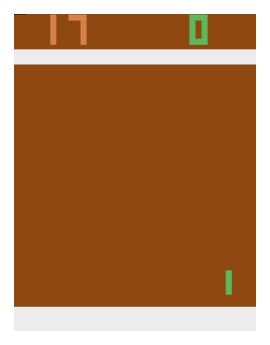

In [14]:
play_game(env, model)

In [15]:
%time hist3 = train_model(env, model, total_episodes=1500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


resetting env. episode 1.000000, reward total was -20.000000. running mean: -20.000000
resetting env. episode 2.000000, reward total was -20.000000. running mean: -20.000000
resetting env. episode 3.000000, reward total was -21.000000. running mean: -20.010000
resetting env. episode 4.000000, reward total was -20.000000. running mean: -20.009900
resetting env. episode 5.000000, reward total was -20.000000. running mean: -20.009801
resetting env. episode 6.000000, reward total was -20.000000. running mean: -20.009703
resetting env. episode 7.000000, reward total was -21.000000. running mean: -20.019606
resetting env. episode 8.000000, reward total was -20.000000. running mean: -20.019410
resetting env. episode 9.000000, reward total was -21.000000. running mean: -20.029216
resetting env. episode 10.000000, reward total was -21.000000. running mean: -20.038924
resetting env. episode 11.000000, reward total was -21.000000. running mean: -20.048534
resetting env. episode 12.000000, reward 

/usr/local/lib/python3.7/dist-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Episode finished without success, accumulated reward = -5.0


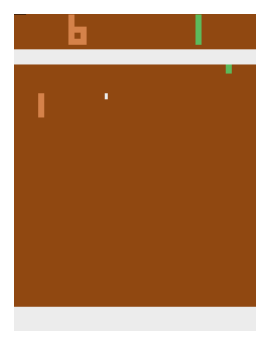

In [16]:
play_game(env, model)